# Plotting pace data

source: Fitbit

In [274]:
import tcxparser 
import pandas as pd
import xmltodict as xml
import collections
from pint import UnitRegistry
import seaborn as sns
import matplotlib.pyplot as plt

In [360]:
# tcxparser tests 
tcx_file = "9785157455.tcx"
tcx_data = tcx.TCXParser(tcx_file)
print(tcx_data.activity_type)
print(tcx_data.completed_at)
print(tcx_data.duration)

# TCX parser doesn't return the distance! WTH!

running
2017-09-08T08:29:24.000-07:00
3573.0


In [281]:
def run_metrics(tcx_file):
    
    """Parses tcx_file. 
    Returns: start time of run and dictionary of lap, distance, and time."""
    
    with open(tcx_file) as tcx:
        try:
            tcx_obj = xml.parse(tcx.read())
            total_dist_m = 0
            total_time_sec = 0
            start_time = str(tcx_obj['TrainingCenterDatabase']['Activities']['Activity']['Lap'][0]['@StartTime'])
            lap_dict = collections.OrderedDict()
            laps = tcx_obj['TrainingCenterDatabase']['Activities']['Activity']['Lap']
            if laps:
                for n, lap in enumerate(laps):
                    lap_dict[n] = float(total_dist_m), float(total_time_sec)
                    total_dist_m+=float(lap['DistanceMeters'])
                    total_time_sec+=float(lap['TotalTimeSeconds'])
                return start_time, total_dist_m, total_time_sec
            else:
                return None
        except:
            print "Error!", tcx_file   
    
# Test function
start, dist_m, time_s = run_metrics('9785157455.tcx')

In [282]:
# Parse files and create a df!

run_data_list = []
import os
for tcx_file in os.listdir('.'):
    tup = run_metrics(tcx_file)
    if tup:
        run_data_list.append(tup)

Error! .DS_Store
Error! 8437947695.tcx
Error! 9022871344.tcx


In [283]:
run_data = pd.DataFrame(run_data_list, columns = ['start', 'distance (m)', 'time (s)'])
run_data['start'] = pd.to_datetime(run_data['start'])

In [284]:
run_data.shape

(93, 3)

In [285]:
run_data.head()

,start,distance (m),time (s)
0,2016-12-31 15:12:00,26600.0,8691.0
1,2017-01-14 15:28:57,29190.0,9552.0
2,2017-01-17 12:59:23,11530.0,3901.0
3,2017-01-19 00:59:18,8170.0,2526.0
4,2017-01-19 19:16:12,10700.0,3262.0


In [286]:
from pint import UnitRegistry
ureg = UnitRegistry()

In [287]:
min_per_mi_list = []

for n, row in run_data.iterrows():
    dist = (row['distance (m)']) * ureg.meter
    miles = dist.to(ureg.mile)
    
    secs = (row['time (s)']) * ureg.seconds
    minutes = secs.to(ureg.minute)
    
    min_per_mile = (minutes/miles).magnitude
    tup = miles, minutes, min_per_mile
    min_per_mi_list.append(tup)

In [288]:
pace_df = pd.DataFrame(min_per_mi_list, columns = ['miles', 'minutes', 'min_per_mile'])
pace_df.head()

,miles,minutes,min_per_mile
0,16.5284737135 mile,144.85 minute,8.763665
1,18.1378251014 mile,159.2 minute,8.777238
2,7.1644098465 mile,65.0166666667 minute,9.074951
3,5.07660264058 mile,42.1 minute,8.292948
4,6.64867175694 mile,54.3666666667 minute,8.177072


In [361]:
# Add pace and create a 'date' only column
run_data[pace_df.columns.tolist()] = pace_df[pace_df.columns.tolist()]
datetime_index_df = pd.DatetimeIndex(run_data['start']).normalize()
run_data['date'] = datetime_index_df.strftime('%D')

# Drop outliers that are likely tracking errors
ind_to_drop = run_data.loc[run_data['min_per_mile'] < 6.5].index.tolist()
run_data.drop(ind_to_drop, inplace=True)
run_data.head()

,start,distance (m),time (s),miles,minutes,min_per_mile,date
0,2016-12-31 15:12:00,26600.0,8691.0,16.5284737135 mile,144.85 minute,8.763665,12/31/16
1,2017-01-14 15:28:57,29190.0,9552.0,18.1378251014 mile,159.2 minute,8.777238,01/14/17
2,2017-01-17 12:59:23,11530.0,3901.0,7.1644098465 mile,65.0166666667 minute,9.074951,01/17/17
3,2017-01-19 00:59:18,8170.0,2526.0,5.07660264058 mile,42.1 minute,8.292948,01/19/17
4,2017-01-19 19:16:12,10700.0,3262.0,6.64867175694 mile,54.3666666667 minute,8.177072,01/19/17


In [342]:
mean_pace = run_data['min_per_mile'].mean()

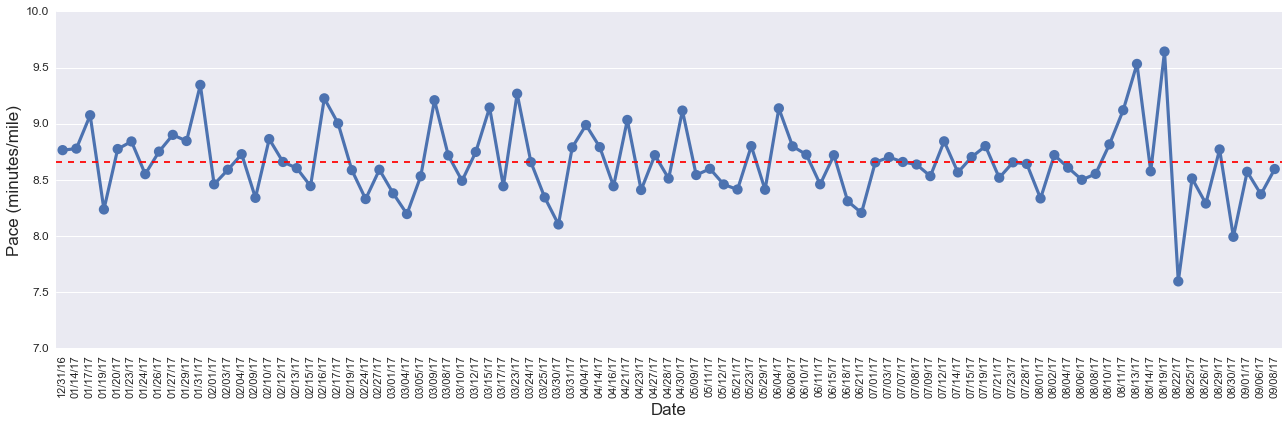

In [343]:
%matplotlib inline 
plt.rcParams['figure.figsize'] = (18, 6)
# plot this shameful data
sns.pointplot(x = run_data['date'], y = run_data['min_per_mile'], ci=None)
plt.axhline(y=mean_pace, color='r', linestyle='--')
plt.xticks(size = 11, rotation='vertical')
plt.ylim(7, 10)
plt.yticks(size=12)
plt.ylabel("Pace (minutes/mile)", size=17)
plt.xlabel("Date", size=17)
plt.tight_layout()
plt.savefig("pace.png")

In [344]:
mean_pace

8.65404988736411

In [359]:
sorted_data = run_data.sort_values(by='min_per_mile', ascending=False)
sorted_data.head(10)

,start,distance (m),time (s),miles,minutes,min_per_mile,date
83,2017-08-19 17:59:07,7010.0,2520.0,4.35581205758 mile,42.0 minute,9.642289,08/19/17
81,2017-08-13 15:01:42,11830.0,4204.0,7.35082120417 mile,70.0666666667 minute,9.531815,08/13/17
11,2017-01-31 13:06:42,11260.0,3923.0,6.99663962459 mile,65.3833333333 minute,9.344962,01/31/17
36,2017-03-23 12:31:33,11060.0,3821.0,6.87236538614 mile,63.6833333333 minute,9.266581,03/23/17
22,2017-02-16 13:30:10,8490.0,2920.0,5.27544142209 mile,48.6666666667 minute,9.225136,02/16/17
30,2017-03-09 13:22:21,11220.0,3852.0,6.9717847769 mile,64.2 minute,9.208546,03/09/17
34,2017-03-15 13:52:57,11130.0,3794.0,6.9158613696 mile,63.2333333333 minute,9.143233,03/15/17
55,2017-06-04 18:21:01,12630.0,4302.0,7.84791815796 mile,71.7 minute,9.136181,06/04/17
80,2017-08-11 13:57:28,8150.0,2771.0,5.06417521673 mile,46.1833333333 minute,9.119616,08/11/17
48,2017-04-30 13:50:32,42610.0,14482.0,26.4766265012 mile,241.366666667 minute,9.116217,04/30/17


In [358]:
run_data[['min_per_mile']].describe()

,min_per_mile
count,92.000000
mean,8.654050
std,0.322611
min,7.593949
25%,8.458543
50%,8.638275
75%,8.797947
max,9.642289
